In [25]:
import pandas as pd
import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score

from skrules import SkopeRules # in skope_rules.py, from sklearn.externals import six must be changed with import six. Also there, you have to change from collections import Counter, Iterable must be changed
# with from collections import Counter and from collections.abc import Iterable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
import matplotlib.pyplot as plt
import os
from os.path import exists

from utilsData import *
from SkopeAlgorithm import *
from UtilsModel import *

import warnings as w
w.filterwarnings('ignore')

import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind, f_oneway, bartlett, levene

In [2]:
data_path = "simulationVictorTopological/"
datafilename = "dataset.csv"

res_path = "simulationVictorTopological/skope/"
if not exists(res_path):
    os.mkdir(res_path)
    
output = "output"

# Train, test, calibration loading

In [3]:
# Verifica si el archivo existe en la carpeta
if os.path.exists(os.path.join(data_path, "train.csv")):
    print("Train.csv exists")
else:
    data = pd.read_csv(data_path+datafilename)
    n_tr = 4000
    n_ts = 1000
    n_c = 5000
    split_dataset(data.drop(["NumberOfCollisions","NumberOfDeadlocks"],axis = 1).values,data.iloc[:,4].values,n_tr,n_ts,n_c,save_path=data_path)


Train.csv exists


In [4]:
data = pd.read_csv(data_path+"dataset.csv")
data[output] = data["NumberOfDeadlocks"].apply(lambda x: 1 if x > 0 else x) # 0 no deadlocks, 1 deadlocks

train = pd.read_csv(data_path+"train.csv")
train[output] = train[output].apply(lambda x: 1 if x > 0 else x)
y_train = train[output]
X_train = train.iloc[:, 3:7] # si quieres solo caracteristicas topol: train.iloc[:, 3:7] 
#si quieres caracteristicas simulaciones + caract topol: train.drop([output],axis = 1

calib = pd.read_csv(data_path+"calib.csv")
calib[output] = calib[output].apply(lambda x: 1 if x > 0 else x)
y_cal = calib[output]
X_cal = calib.iloc[:, 3:7] 

test = pd.read_csv(data_path+"test.csv")
test[output] = test[output].apply(lambda x: 1 if x > 0 else x)
y_test = test[output]
X_test = test.iloc[:, 3:7] 


# Exploratory analisis

In [6]:
print(sum(y_train)+sum(y_cal)+sum(y_test))
pd.value_counts(data[output]) # is balanced in terms of simulations with deadlocks/no deadlocks

5757


output
1    5757
0    4243
Name: count, dtype: int64

## Correlation

In [7]:
correlation_matrix = data.corr()
print(correlation_matrix["NumberOfDeadlocks"])

SafetyMargin          0.895289
Eta                   0.020856
Tau                  -0.047071
NumberOfCollisions   -0.197683
NumberOfDeadlocks     1.000000
meanEntropy           0.790115
medianEntropy         0.788901
stdsEntropy          -0.071073
iqrsEntropy           0.093666
output                0.931656
Name: NumberOfDeadlocks, dtype: float64


## Dispersion plots

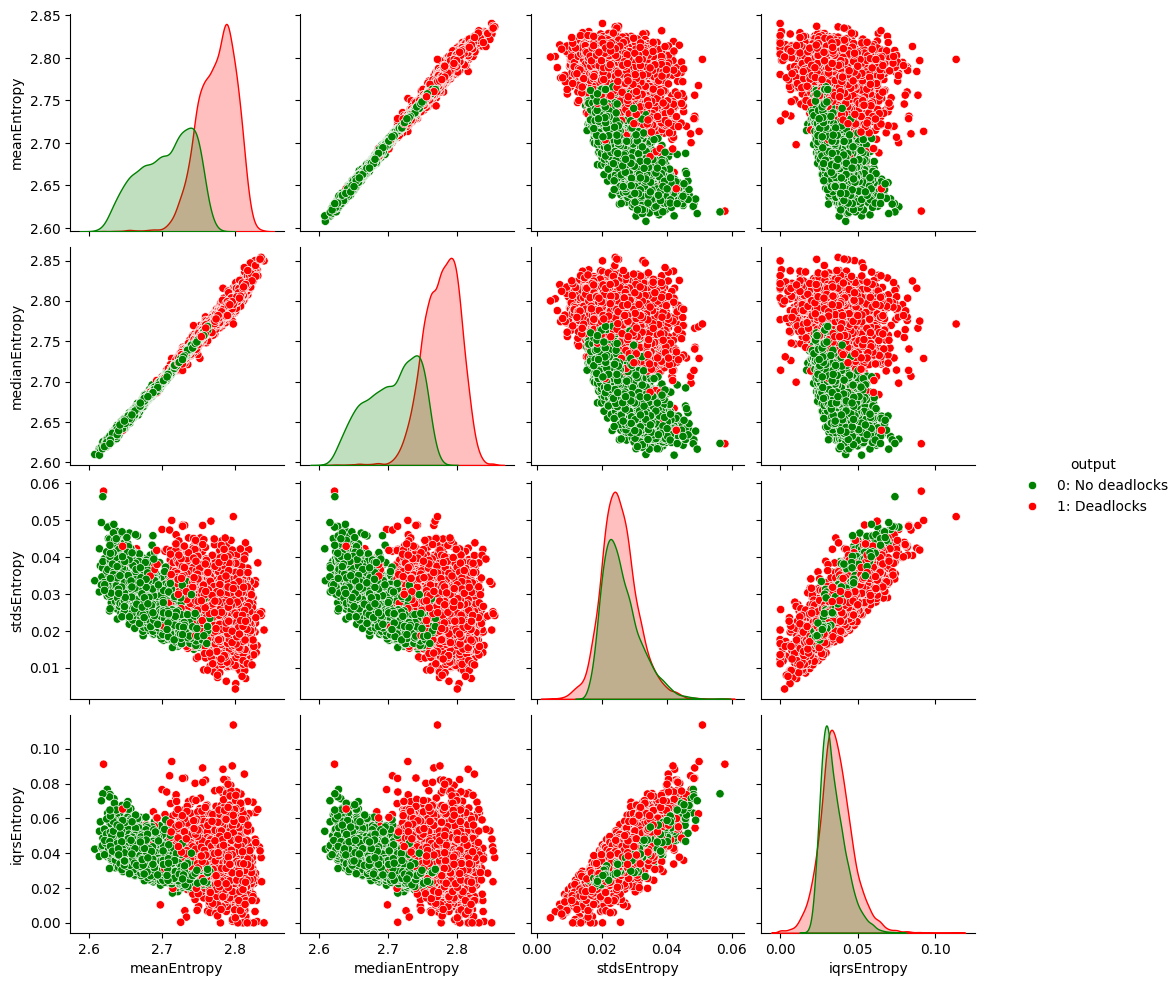

In [19]:
pairplot = sns.pairplot(data, vars=['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy'], hue='output', hue_order=[0,1],
                        palette=['green', 'red'], kind="scatter",diag_kind="kde")
new_labels = ['0: No deadlocks', '1: Deadlocks']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
pairplot._legend.set_bbox_to_anchor((0.95, 0.5))
pairplot._legend.set_loc("center left")  
plt.show()

## Boxplots

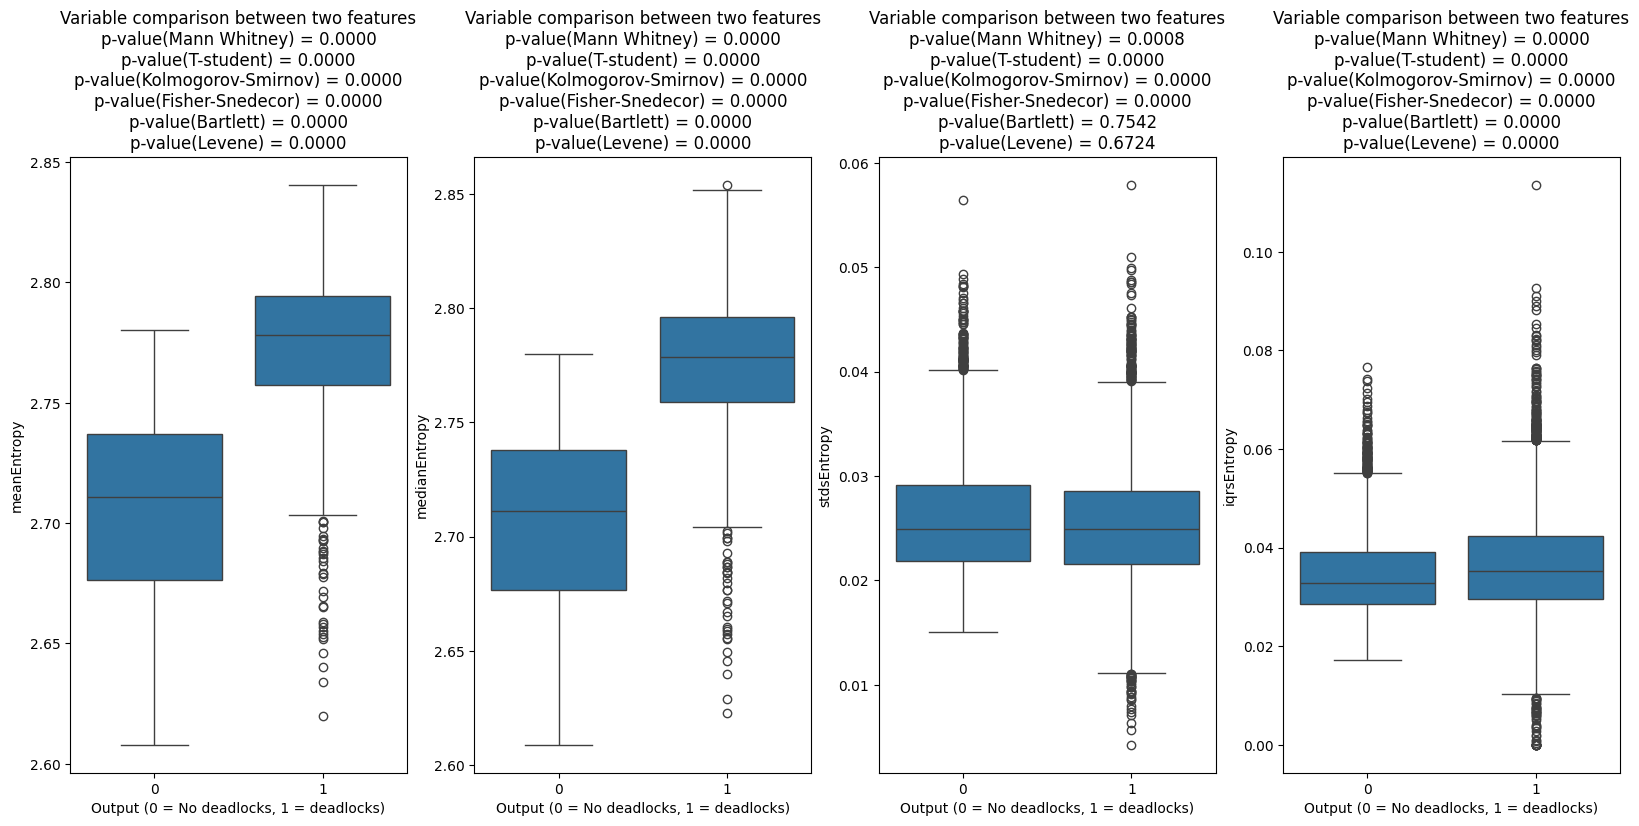

In [26]:
tests = [
    ('Mann Whitney', mannwhitneyu, {"alternative": "two-sided"}),
    ('T-student', ttest_ind, {"equal_var": True}),
    ('Kolmogorov-Smirnov', ks_2samp, {"alternative": "two-sided"}),
    ('Fisher-Snedecor', f_oneway, {}),
    ('Bartlett', bartlett, {}),
    ('Levene', levene, {}),
]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']):
    Cvalues = data[data["output"] == 1][i].values
    NCvalues = data[data["output"] == 0][i].values
    # stat1, p_value1 = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    # stat2, p_value2 = ttest_ind(Cvalues, NCvalues,equal_var=True)
    # stat3, p_value3 = ks_2samp(Cvalues, NCvalues, alternative="two-sided")
    # plt.sca(axes[num])
    # sns.boxplot(x='output', y=i, data=data)
    # plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value1:.4f} \n p-value(T-student) = {p_value2:.4f} \n p-value(Kolmogorv-Smirnov) = {p_value3:.4f}')

    p_values = [f'p-value({name}) = {test(Cvalues, NCvalues, **params)[1]:.4f}' for name, test, params in tests]
    plt.sca(axes[num])
    sns.boxplot(x='output', y=i, data=data)
    plt.title("Variable comparison between two features\n" + "\n".join(p_values))
    plt.xlabel("Output (0 = No deadlocks, 1 = deadlocks)")
    plt.ylabel(i)

plt.show()

# Skope Rules for output = 1 (deadlock class)

In [9]:
param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = True, rules_path = res_path+"skope_rules_deadlocks.csv", save_model = True, save_path = res_path+"skope_best_deadlocks.sav")


Time spent for Randomized Search:  275.91173553466797  s
0.8455676908914798 {'precision_min': 0.9, 'n_estimators': 10, 'max_depth_duplication': 3}
0.8874416753510184 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 2}
0.8866679564266147 {'precision_min': 0.8, 'n_estimators': 100, 'max_depth_duplication': 2}
0.8770545693766916 {'precision_min': 0.9, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8904566436301657 {'precision_min': 0.7, 'n_estimators': 50, 'max_depth_duplication': 2}
0.9079753365477506 {'precision_min': 0.6, 'n_estimators': 100, 'max_depth_duplication': 5}
0.9046120455779411 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 3}
0.908350352763519 {'precision_min': 0.5, 'n_estimators': 10, 'max_depth_duplication': 5}
0.9040244570745823 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 5}
0.9040244570745823 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 7}
SkopeRules best parameters with Rando

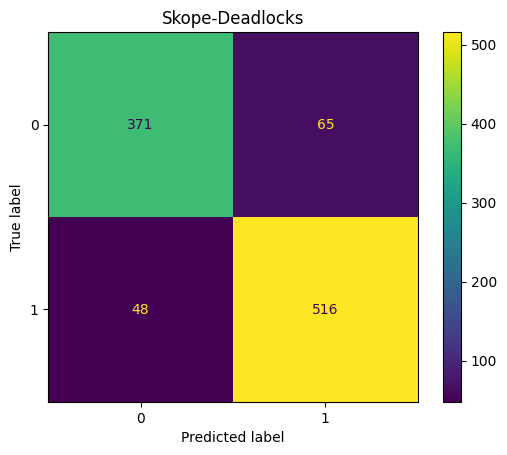

ACC = 0.887, F1 = 0.9013100436681223, PPV = 0.8881239242685026, NPV = 0.8854415274463007, TPR = 0.9148936170212766, TNR = 0.8509174311926605

TP = 516, FP = 65, TN = 371, FN = 48


In [10]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-Deadlocks")


# Skope rules for output = 0 (non deadlocks)

Swap labels to denote non collisions with 1


In [11]:
y_train = 1-y_train
y_test = 1-y_test
y_cal = 1- y_cal

In [12]:
# parameters optimization with RandomizedCV

param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = True, rules_path = res_path+"skope_rules_nondeadlocks.csv", save_model = True, save_path = res_path+"skope_best_nondeadlocks.sav")


Time spent for Randomized Search:  279.0902564525604  s
0.7166807402741625 {'precision_min': 0.9, 'n_estimators': 10, 'max_depth_duplication': 3}
0.8167199003957923 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 2}
0.8450660639483608 {'precision_min': 0.8, 'n_estimators': 100, 'max_depth_duplication': 2}
0.7702450687416992 {'precision_min': 0.9, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8172808458424494 {'precision_min': 0.7, 'n_estimators': 50, 'max_depth_duplication': 2}
0.8604511087877965 {'precision_min': 0.6, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8618094467002806 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8694052222408668 {'precision_min': 0.5, 'n_estimators': 10, 'max_depth_duplication': 5}
0.8673933910047383 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8673933910047383 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 7}
SkopeRules best parameters with Rando

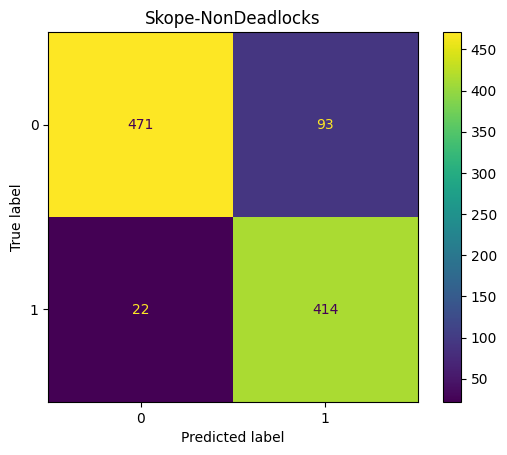

ACC = 0.885, F1 = 0.8780487804878049, PPV = 0.8165680473372781, NPV = 0.9553752535496958, TPR = 0.9495412844036697, TNR = 0.8351063829787234

TP = 414, FP = 93, TN = 471, FN = 22


In [13]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-NonDeadlocks")